# Bootstrapping LMMs using ReTerms

This notebook requires a relatively recent version of the unpublished `ReTerms` package

In [1]:
if !isdir(Pkg.dir("ReTerms"))
    Pkg.clone("git@github.com:dmbates/ReTerms.jl")
end
#Pkg.update()   # to ensure the latest versions

In the `ReTerms` package a linear mixed-effects model is represented by a vector of terms, `trms`, a vector of parameterized lower triangular matrices, `Λ`, a blocked symmetric matrix, `A`, and a blocked upper triangular Cholesky factor, `R`.

The `k` elements of `Λ` correspond to the grouping factors for the random effects.  The `trms` vector is of length `k+1`.  The first `k` elements are implicit representations blocks in $\bf Z$.  The last element is the horizontal concatenation of the fixed-effects model matrix, $\bf X$ and the response vector $\bf y$.

The symmetric matrix `A`, of which only the upper triangle is stored, represents
$$
\begin{bmatrix}
\bf Z'Z & \bf Z'X & \bf Z'y\\
\bf X'Z & \bf X'X & \bf X'y\\
\bf y'Z & \bf y'X & \bf y'y
\end{bmatrix}
$$
but the blocking scheme corresponds to the `trms` vector.  The same blocking scheme is used for the upper Cholesky factor `R`.

A couple of familiar examples may be helpful.

## The `Dyestuff` example

In [2]:
using DataFrames,ReTerms
include(Pkg.dir("ReTerms","test","data.jl"));
dump(ds)  # the Dyestuff data

DataFrames.DataFrame  30 observations of 2 variables
  Yield: DataArrays.DataArray{Float64,1}(30) [1545.0,1440.0,1440.0,1520.0]
  Batch: DataArrays.PooledDataArray{Char,UInt8,1}(30) ['A','A','A','A']


In [3]:
m1 = LMM([ReMat(ds[:Batch])],ds[:Yield]);
length(m1.trms)

2

In [4]:
m1.trms[2]'

2x30 Array{Float64,2}:
    1.0     1.0     1.0     1.0     1.0  …     1.0     1.0     1.0     1.0
 1545.0  1440.0  1440.0  1520.0  1580.0     1455.0  1450.0  1480.0  1445.0

In [5]:
m1[:θ]  # parameter vector

1-element Array{Float64,1}:
 1.0

In [6]:
m1.Λ

1-element Array{ReTerms.ColMajorLowerTriangular{Float64,Array{Float64,2}},1}:
 1x1 ReTerms.ColMajorLowerTriangular{Float64,Array{Float64,2}}:
 1.0

In [7]:
m1.A[2,2]

2x2 Array{Float64,2}:
    30.0  45825.0      
 45825.0      7.01129e7

For small examples and when running parallel simulations it is best to allow only one BLAS thread.

In [8]:
blas_set_num_threads(1)
fit(m1,true);

f_1: 327.76702, [1.0]
f_2: 331.03619, [1.75]
f_3: 330.64583, [0.25]
f_4: 327.69511, [0.97619]
f_5: 327.56631, [0.928569]
f_6: 327.3826, [0.833327]
f_7: 327.35315, [0.807188]
f_8: 327.34663, [0.799688]
f_9: 327.341, [0.792188]
f_10: 327.33253, [0.777188]
f_11: 327.32733, [0.747188]
f_12: 327.32862, [0.739688]
f_13: 327.32706, [0.752777]
f_14: 327.32707, [0.753527]
f_15: 327.32706, [0.752584]
f_16: 327.32706, [0.752509]
f_17: 327.32706, [0.752591]
f_18: 327.32706, [0.752581]
FTOL_REACHED


In [9]:
m1.Λ

1-element Array{ReTerms.ColMajorLowerTriangular{Float64,Array{Float64,2}},1}:
 1x1 ReTerms.ColMajorLowerTriangular{Float64,Array{Float64,2}}:
 0.752581

In [10]:
m1.R[1,1]

6x6 Diagonal{Float64}:
 1.95752  0.0      0.0      0.0      0.0      0.0    
 0.0      1.95752  0.0      0.0      0.0      0.0    
 0.0      0.0      1.95752  0.0      0.0      0.0    
 0.0      0.0      0.0      1.95752  0.0      0.0    
 0.0      0.0      0.0      0.0      1.95752  0.0    
 0.0      0.0      0.0      0.0      0.0      1.95752

In [11]:
m1.R[1,2]

6x2 Array{Float64,2}:
 1.92228  2893.03
 1.92228  2937.24
 1.92228  3006.45
 1.92228  2879.58
 1.92228  3075.65
 1.92228  2825.75

In [12]:
m1.R[2,2]

2x2 Array{Float64,2}:
     2.79804  4274.01 
 45825.0       271.178

In [13]:
pwrss(m1)

73537.50076827034

In [14]:
√pwrss(m1)

271.17798724872625

The steps in evaluating the objective function are to split the parameter vector over the `Λ` vector, copy `A` into `R` (upper triangle) and update its blocks, except for the last column, to $\bf\Lambda'Z'Z\Lambda+I$, then perform the blocked Cholesky factorization.  As seen above, the lower right element of the lower right block of `R` is the square root of the penalized residual sum-of-squares.

During the iterations there is no need to solve for the coefficients and there are no operations that involve vectors of length `n` or matrices with a dimension `n`.

## The `sleepstudy` example

In [15]:
dump(slp)

DataFrames.DataFrame  180 observations of 3 variables
  Reaction: DataArrays.DataArray{Float64,1}(180) [249.56,258.7047,250.8006,321.4398]
  Days: DataArrays.DataArray{Int64,1}(180) [0,1,2,3]
  Subject: DataArrays.PooledDataArray{Int64,UInt8,1}(180) [1,1,1,1]


In [16]:
const X = hcat(ones(size(slp,1)),slp[:Days]);
X'

2x180 Array{Float64,2}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0     3.0  4.0  5.0  6.0  7.0  8.0  9.0

In [17]:
m2 = fit(LMM([VectorReMat(slp[:Subject],X')],X,slp[:Reaction]),true);

f_1: 1784.6423, [1.0,0.0,1.0]
f_2: 1790.12564, [1.75,0.0,1.0]
f_3: 1798.99962, [1.0,1.0,1.0]
f_4: 1803.8532, [1.0,0.0,1.75]
f_5: 1800.61398, [0.25,0.0,1.0]
f_6: 1798.60463, [1.0,-1.0,1.0]
f_7: 1752.26074, [1.0,0.0,0.25]
f_8: 1797.58769, [1.18326,-0.00866189,0.0]
f_9: 1754.95411, [1.075,0.0,0.325]
f_10: 1753.69568, [0.816632,0.0111673,0.288238]
f_11: 1754.817, [1.0,-0.0707107,0.196967]
f_12: 1753.10673, [0.943683,0.0638354,0.262696]
f_13: 1752.93938, [0.980142,-0.0266568,0.274743]
f_14: 1752.25688, [0.984343,-0.0132347,0.247191]
f_15: 1752.05745, [0.97314,0.00253785,0.23791]
f_16: 1752.02239, [0.954526,0.00386421,0.235892]
f_17: 1752.02273, [0.935929,0.0013318,0.234445]
f_18: 1751.97169, [0.954965,0.00790664,0.229046]
f_19: 1751.9526, [0.953313,0.0166274,0.225768]
f_20: 1751.94852, [0.946929,0.0130761,0.222871]
f_21: 1751.98718, [0.933418,0.00613767,0.218951]
f_22: 1751.98321, [0.951544,0.005789,0.220618]
f_23: 1751.95197, [0.952809,0.0190332,0.224178]
f_24: 1751.94628, [0.946322,0.0153

In [18]:
gc(); @time fit(LMM([VectorReMat(slp[:Subject],X')],X,slp[:Reaction]));

  0.016701 seconds (34.42 k allocations: 1.311 MB)


In [19]:
gc(); @time fit(LMM([VectorReMat(slp[:Subject],X')],X,slp[:Reaction]));

  0.002005 seconds (31.43 k allocations: 1.159 MB)


In [20]:
UpperTriangular(m2.R[end,end])

3x3 UpperTriangular{Float64,Array{Float64,2}}:
 3.89572   2.36568  1004.17 
 0.0      17.0358    178.319
 0.0       0.0       343.35 

In [21]:
m2.R[1,1]  # a homogeneous block diagonal matrix - all blocks are the same size

36x36 ReTerms.HBlkDiag{Float64}:
  3.35381  3.11966   0.0      0.0      …  0.0       0.0      0.0    
 10.4627   2.3228    0.0      0.0         0.0       0.0      0.0    
  0.0      0.0       3.35381  3.11966     0.0       0.0      0.0    
  0.0      0.0      10.4627   2.3228      0.0       0.0      0.0    
  0.0      0.0       0.0      0.0         0.0       0.0      0.0    
  0.0      0.0       0.0      0.0      …  0.0       0.0      0.0    
  0.0      0.0       0.0      0.0         0.0       0.0      0.0    
  0.0      0.0       0.0      0.0         0.0       0.0      0.0    
  0.0      0.0       0.0      0.0         0.0       0.0      0.0    
  0.0      0.0       0.0      0.0         0.0       0.0      0.0    
  0.0      0.0       0.0      0.0      …  0.0       0.0      0.0    
  0.0      0.0       0.0      0.0         0.0       0.0      0.0    
  0.0      0.0       0.0      0.0         0.0       0.0      0.0    
  ⋮                                    ⋱                     ⋮      
 

Only the upper triangle of the blocks on the diagonal of `m2.R[1,1]` is used.  The diagonal blocks are stored as a 3-dimensional array, of size $2\times2\times18$ in this case.  The `[1,1]` block of `A` and of `R` is always diagonal or homogeneous block diagonal with small blocks.  Thus we order multiple random-effects terms by decreasing number of columns in the relevant block of $\bf Z$.

## The `penicillin` example

In [22]:
dump(pen)

DataFrames.DataFrame  144 observations of 3 variables
  Diameter: DataArrays.DataArray{Int64,1}(144) [27,23,26,23]
  Plate: DataArrays.PooledDataArray{Char,UInt8,1}(144) ['a','a','a','a']
  Sample: DataArrays.PooledDataArray{Char,UInt8,1}(144) ['A','B','C','D']


In [23]:
m3 = fit(LMM([ReMat(pen[s]) for s in [:Plate,:Sample]],pen[:Diameter]),true);

f_1: 364.62678, [1.0,1.0]
f_2: 366.266, [1.75,1.0]
f_3: 343.18172, [1.0,1.75]
f_4: 420.30904, [0.25,1.0]
f_5: 527.30742, [1.0,0.25]
f_6: 342.96938, [1.35355,1.48888]
f_7: 346.15225, [1.01828,1.51072]
f_8: 340.16913, [1.26954,1.6565]
f_9: 338.39374, [1.22337,1.82469]
f_10: 336.60521, [1.20946,2.05699]
f_11: 336.12166, [1.20209,2.15635]
f_12: 336.30747, [1.14293,2.32547]
f_13: 334.87947, [1.27813,2.24444]
f_14: 334.02917, [1.338,2.34421]
f_15: 332.96376, [1.44753,2.54955]
f_16: 332.67606, [1.48968,2.65312]
f_17: 332.51507, [1.52191,2.73832]
f_18: 332.54569, [1.45322,2.76843]
f_19: 332.45582, [1.50406,2.78315]
f_20: 332.48246, [1.49754,2.76674]
f_21: 332.43315, [1.515,2.79702]
f_22: 332.41102, [1.51999,2.81396]
f_23: 332.37037, [1.52404,2.84905]
f_24: 332.3032, [1.52909,2.91951]
f_25: 332.21824, [1.53232,3.06076]
f_26: 332.1924, [1.53447,3.15996]
f_27: 332.19421, [1.51795,3.19667]
f_28: 332.21805, [1.49525,3.15089]
f_29: 332.18902, [1.5331,3.19953]
f_30: 332.18889, [1.53225,3.20698]
f_31:

In [24]:
m3.A[1,2]

24x6 Array{Float64,2}:
 1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0

In [25]:
m3.A[2,2]

6x6 Diagonal{Float64}:
 24.0   0.0   0.0   0.0   0.0   0.0
  0.0  24.0   0.0   0.0   0.0   0.0
  0.0   0.0  24.0   0.0   0.0   0.0
  0.0   0.0   0.0  24.0   0.0   0.0
  0.0   0.0   0.0   0.0  24.0   0.0
  0.0   0.0   0.0   0.0   0.0  24.0

In [26]:
m3.R[1,2]

24x6 Array{Float64,2}:
 1.27044  1.27044  1.27044  1.27044  1.27044  1.27044
 1.27044  1.27044  1.27044  1.27044  1.27044  1.27044
 1.27044  1.27044  1.27044  1.27044  1.27044  1.27044
 1.27044  1.27044  1.27044  1.27044  1.27044  1.27044
 1.27044  1.27044  1.27044  1.27044  1.27044  1.27044
 1.27044  1.27044  1.27044  1.27044  1.27044  1.27044
 1.27044  1.27044  1.27044  1.27044  1.27044  1.27044
 1.27044  1.27044  1.27044  1.27044  1.27044  1.27044
 1.27044  1.27044  1.27044  1.27044  1.27044  1.27044
 1.27044  1.27044  1.27044  1.27044  1.27044  1.27044
 1.27044  1.27044  1.27044  1.27044  1.27044  1.27044
 1.27044  1.27044  1.27044  1.27044  1.27044  1.27044
 1.27044  1.27044  1.27044  1.27044  1.27044  1.27044
 1.27044  1.27044  1.27044  1.27044  1.27044  1.27044
 1.27044  1.27044  1.27044  1.27044  1.27044  1.27044
 1.27044  1.27044  1.27044  1.27044  1.27044  1.27044
 1.27044  1.27044  1.27044  1.27044  1.27044  1.27044
 1.27044  1.27044  1.27044  1.27044  1.27044  1.27044
 1.27

In [27]:
UpperTriangular(m3.R[2,2])

6x6 UpperTriangular{Float64,Array{Float64,2}}:
 14.5281  -2.6663  -2.6663   -2.6663   -2.6663   -2.6663 
  0.0     14.2814  -3.21016  -3.21016  -3.21016  -3.21016
  0.0      0.0     13.9159   -4.035    -4.035    -4.035  
  0.0      0.0      0.0      13.3181   -5.43861  -5.43861
  0.0      0.0      0.0       0.0      12.157    -8.39108
  0.0      0.0      0.0       0.0       0.0       8.79674

In [28]:
UpperTriangular(m3.R[3,3])

2x2 UpperTriangular{Float64,Array{Float64,2}}:
 0.738566  16.9665
 0.0        6.5992

In this example the product

In [29]:
m3.A[1,2]'m3.A[1,2]

6x6 Array{Float64,2}:
 24.0  24.0  24.0  24.0  24.0  24.0
 24.0  24.0  24.0  24.0  24.0  24.0
 24.0  24.0  24.0  24.0  24.0  24.0
 24.0  24.0  24.0  24.0  24.0  24.0
 24.0  24.0  24.0  24.0  24.0  24.0
 24.0  24.0  24.0  24.0  24.0  24.0

is dense, hence `m3.R[2,2]` becomes dense even though `m3.A[2,2]` is diagonal.

In [30]:
gc(); @time fit(LMM([ReMat(pen[s]) for s in [:Plate,:Sample]],pen[:Diameter]));

  0.005456 seconds (10.29 k allocations: 207.938 KB)


In [31]:
gc(); @time fit(LMM([ReMat(pen[s]) for s in [:Plate,:Sample]],pen[:Diameter]));

  0.001075 seconds (10.26 k allocations: 206.234 KB)


## The `Pastes` example

In [32]:
dump(psts)

DataFrames.DataFrame  60 observations of 4 variables
  Strength: DataArrays.DataArray{Float64,1}(60) [62.8,62.6,60.1,62.3]
  Batch: DataArrays.PooledDataArray{Char,UInt8,1}(60) ['A','A','A','A']
  Cask: DataArrays.PooledDataArray{Char,UInt8,1}(60) ['a','a','b','b']
  Sample: DataArrays.PooledDataArray{ASCIIString,UInt8,1}(60) ASCIIString["Aa","Aa","Ab","Ab"]


In [33]:
m4 = fit(LMM([ReMat(psts[s]) for s in [:Sample,:Batch]],psts[:Strength]),true);

f_1: 274.8397, [1.0,1.0]
f_2: 258.56865, [1.75,1.0]
f_3: 277.39618, [1.0,1.75]
f_4: 300.92218, [0.25,1.0]
f_5: 279.7496, [1.0,0.25]
f_6: 250.93944, [2.49601,1.07724]
f_7: 249.5404, [2.74867,1.15646]
f_8: 248.64833, [2.98474,1.63052]
f_9: 248.59997, [2.99408,1.54877]
f_10: 248.43446, [3.0687,1.54124]
f_11: 248.29936, [3.14346,1.53526]
f_12: 248.15509, [3.26562,1.58041]
f_13: 248.20737, [3.38606,1.81135]
f_14: 248.05426, [3.38994,1.54163]
f_15: 248.05921, [3.49885,1.61304]
f_16: 248.0504, [3.43672,1.57657]
f_17: 248.04172, [3.43144,1.54874]
f_18: 248.02318, [3.4418,1.49304]
f_19: 248.01406, [3.42417,1.38112]
f_20: 248.0061, [3.44879,1.38228]
f_21: 247.99886, [3.47775,1.35361]
f_22: 247.99762, [3.48518,1.34275]
f_23: 247.99844, [3.48937,1.30221]
f_24: 247.99559, [3.50242,1.3319]
f_25: 247.99468, [3.51952,1.32081]
f_26: 247.99472, [3.52475,1.31303]
f_27: 247.9945, [3.52317,1.32736]
f_28: 247.99448, [3.5253,1.33384]
f_29: 247.99448, [3.52484,1.33222]
f_30: 247.99447, [3.52599,1.33059]
f_31:

In [34]:
m4.R[1,2]

30x10 sparse matrix with 30 Float64 entries:
	[1 ,  1]  =  1.8441
	[2 ,  1]  =  1.8441
	[3 ,  1]  =  1.8441
	[4 ,  2]  =  1.8441
	[5 ,  2]  =  1.8441
	[6 ,  2]  =  1.8441
	[7 ,  3]  =  1.8441
	[8 ,  3]  =  1.8441
	[9 ,  3]  =  1.8441
	[10,  4]  =  1.8441
	⋮
	[20,  7]  =  1.8441
	[21,  7]  =  1.8441
	[22,  8]  =  1.8441
	[23,  8]  =  1.8441
	[24,  8]  =  1.8441
	[25,  9]  =  1.8441
	[26,  9]  =  1.8441
	[27,  9]  =  1.8441
	[28, 10]  =  1.8441
	[29, 10]  =  1.8441
	[30, 10]  =  1.8441

In [35]:
m4.R[1,2]'m4.R[1,2]

10x10 sparse matrix with 10 Float64 entries:
	[1 ,  1]  =  10.2021
	[2 ,  2]  =  10.2021
	[3 ,  3]  =  10.2021
	[4 ,  4]  =  10.2021
	[5 ,  5]  =  10.2021
	[6 ,  6]  =  10.2021
	[7 ,  7]  =  10.2021
	[8 ,  8]  =  10.2021
	[9 ,  9]  =  10.2021
	[10, 10]  =  10.2021

Because this product is diagonal, `m4.R[2,2]` is also diagonal.

In [36]:
m4.R[2,2]

10x10 Diagonal{Float64}:
 1.18747  0.0      0.0      0.0      …  0.0      0.0      0.0      0.0    
 0.0      1.18747  0.0      0.0         0.0      0.0      0.0      0.0    
 0.0      0.0      1.18747  0.0         0.0      0.0      0.0      0.0    
 0.0      0.0      0.0      1.18747     0.0      0.0      0.0      0.0    
 0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0    
 0.0      0.0      0.0      0.0      …  0.0      0.0      0.0      0.0    
 0.0      0.0      0.0      0.0         1.18747  0.0      0.0      0.0    
 0.0      0.0      0.0      0.0         0.0      1.18747  0.0      0.0    
 0.0      0.0      0.0      0.0         0.0      0.0      1.18747  0.0    
 0.0      0.0      0.0      0.0         0.0      0.0      0.0      1.18747

## Bootstrapping

In working on some simulations of data from a model and fitting that model and a couple of others to it, I realized that I was essentially doing a parametric bootstrap.  I wrote a `bootstrap` that uses a callback to accumulate the desired result.  Suppose that I want to save the fixed-effects, their standard errors and the deviance from 10,000 parametric bootstrap fits of model m2. 

In [37]:
N = 10000;
const betamat = zeros(2,N);
const stderrmat = zeros(2,N);
const devvec = zeros(N);
function saveresults(i::Integer,m::LMM)  # the callback function
    copy!(sub(betamat,:,i),coef(m))
    copy!(sub(stderrmat,:,i),stderr(m))
    devvec[i] = objective(m)
end

saveresults (generic function with 1 method)

In [38]:
gc(); @time ReTerms.bootstrap(m2,N,saveresults);

 19.080397 seconds (344.81 M allocations: 12.265 GB, 10.94% gc time)


In [39]:
using Gadfly

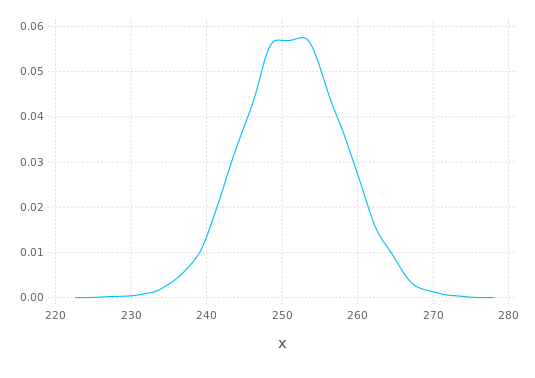

In [40]:
plot(x=sub(betamat,1,:),Geom.density)

There is still quite a bit to do but I think that 10,000 bootstrap fits in under 20 seconds is pretty good.  The next stage is parallelization.